# **Multi-Class Feature** Metapath2vec Embeddings, Discrimination Potential Example

Yuxiao Dong, Nitesh V. Chawla, and Ananthram Swami. 2017. Metapath2vec: Scalable Representation Learning for Heterogeneous Networks. In Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '17). Association for Computing Machinery, New York, NY, USA, 135–144. https://doi.org/10.1145/3097983.3098036

Unbiased embeddings should not take into account the sensitive attributes of the users. Rather the embedding representations of users should rather be accquired by solely utilizing the interactions users have with their content. This is infact what makes users different from eachother. These unbisaed embeddings allow us to define clusters of similar users, where similar suggests that users who interact similarly should be closer together in the respective embedding space.

NOTE: These embeddings are generated in an unbiased manner. This does not mean they do not have discrimination potential, if interested in the combination of fair embeddings for homogenous graphs read up on FairWalk https://www.ijcai.org/Proceedings/2019/456. (A "fairwalk" like approach for heterogenous graph embeddings generated from metapath2vec has not been implemented ;)... I seriously recommend looking into developing this, as it could push the field of fair representation learning forward)

In this paricular notebook...

I will use the following dataset to generate embeddings, and deploy two classification techniques to predict the sensitive attribute

**Dataset: ML100k - Pytorch Geometric Graph Dataset**

**Attribute: Occupation (Multi-Class)**

     'administrator': 0,
     'artist': 1,
     'doctor': 2,
     'educator': 3,
     'engineer': 4,
     'entertainment': 5,
     'executive': 6,
     'healthcare': 7,
     'homemaker': 8,
     'lawyer': 9,
     'librarian': 10,
     'marketing': 11,
     'none': 12,
     'other': 13,
     'programmer': 14,
     'retired': 15,
     'salesman': 16,
     'scientist': 17,
     'student': 18,
     'technician': 19,
     'writer': 20

# Imports

Notice that this notebook requires the imports from pytorch_geometric. This library must be installed specific to the running device. Find and install the configuration 

https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

In [1]:
#!pip or conda install ............

In [2]:
import torch
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import Pytorch Geometric ML100k Dataset

I went ahead and configured a customized pytorch geometric dataset to show you just what needs to be configured inorder to define customized pytorch dataset classes if you would like to utilize their framework later for the project. 

Most importantly however, is the graph dataset attribute labelled "edge_index_dict." 

Notice: I have not added all possible features of the movies or users, more configuration can be made to the custom dataset loader. See documentation for all your pytorch geometric heterogeneous graph needs: https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html?highlight=edge_index_dict

In [3]:
from ml100k import ML100k
dataset = ML100k('../data/ml-100k')
hg = dataset[0]
hg

Using existing file ml-100k.zip


HeteroData(
  user={
    num_nodes=943,
    user_index=[943],
    gender=[943],
    age=[943],
    occupation=[943],
    zip_code=[943]
  },
  movie={
    num_nodes=1682,
    user_index=[1682],
    genre=[1682]
  },
  (user, rates, movie)={
    edge_index=[2, 100000],
    edge_rating=[100000],
    edge_timestamp=[100000]
  }
)

# Adding reverse edges to the graph

In [4]:
import torch_geometric.transforms as T
hg = T.ToUndirected()(hg)
hg

HeteroData(
  user={
    num_nodes=943,
    user_index=[943],
    gender=[943],
    age=[943],
    occupation=[943],
    zip_code=[943]
  },
  movie={
    num_nodes=1682,
    user_index=[1682],
    genre=[1682]
  },
  (user, rates, movie)={
    edge_index=[2, 100000],
    edge_rating=[100000],
    edge_timestamp=[100000]
  },
  (movie, rev_rates, user)={
    edge_index=[2, 100000],
    edge_rating=[100000],
    edge_timestamp=[100000]
  }
)

# Implementing metapath2vec

The requirements to implement the metapath2vec alogithm is a python dictionary holding keys of the format (source_node, relation_type, destination_node), 
and tensor array values of the format...

    {('user',
      'rates',
      'movie'): tensor([[ 195,  185,   21,  ...,  275,   12,   11],
             [ 241,  301,  376,  ..., 1089,  224,  202]]),
     ('movie',
      'rev_rates',
      'user'): tensor([[ 241,  301,  376,  ..., 1089,  224,  202],
             [ 195,  185,   21,  ...,  275,   12,   11]])}
    
and a "metapath".. an array of your dictionary keys for a random walk algorithm to select from.

    metapath= [
        ('user', 'rates', 'movie'),
        ('movie', 'rev_rates', 'user'),
    ]

Notice: The custom configuration of a dataset is clearly not what is required, but I made for the purpose of providing as much additional resources. The dictionary input must contain the reverse edges. This means for every key value pair, you must provide a reverse key, and reverse value pair.  For more information on the

In [ ]:
dataset.metapath

In [5]:
from utils import get_metapath2vec_embbeddings

embedding_dict = get_metapath2vec_embbeddings(hg.edge_index_dict, dataset.metapath, device)
embedding_dict

 Training metapath2vec embedding representations Epoch: 25 of 25, Step: 8.000/8, Loss: 1.339 

{'user': tensor([[-0.1264,  0.0684,  0.0115,  ..., -0.5895, -0.0820, -0.0891],
         [-0.0717,  0.0538, -0.1814,  ..., -0.2133, -0.0078, -0.0864],
         [-0.4255,  0.3283,  1.1917,  ...,  0.2098, -0.0372,  0.0204],
         ...,
         [ 0.1969, -0.0312, -0.0368,  ...,  0.1153,  0.0016, -0.0207],
         [ 0.1290, -0.0307, -0.1051,  ...,  1.0358,  0.8821,  0.1132],
         [-0.2070, -0.0651,  0.2548,  ..., -0.3821,  0.0300, -0.1529]]),
 'movie': tensor([[-0.4233, -0.1222, -0.0438,  ...,  0.6079, -0.2590, -0.2224],
         [ 0.0241, -0.2466, -0.4485,  ...,  0.3629, -0.0921,  0.5597],
         [-0.0413,  0.1505, -0.1571,  ...,  0.2049, -0.0598,  0.2327],
         ...,
         [-0.4029,  0.5405,  0.1112,  ..., -0.3161, -0.0489,  0.2525],
         [ 0.0661, -0.1902,  0.1395,  ..., -0.1366, -0.1000,  0.1379],
         [ 0.1096, -1.2473,  0.1371,  ..., -0.3442,  0.3921,  0.2329]])}

# Predicting the sensitive attribute to identify discrimination potential
If isn't immediately obvious, we now have not only high dimensional user representations, but also high dimension movie represenations. This is where the power of dimensionality reduction methods shine. 

For our case, I'll be using the sklearn TSNE method. Many others are available and widely encouraged for dimensionality reduction (like UMAP)
https://pair-code.github.io/understanding-umap/#:~:text=UMAP%20vs%20t-SNE%2C%20revisited%20The%20biggest%20difference%20between,relations%20are%20potentially%20more%20meaningful%20than%20in%20t-SNE.

/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


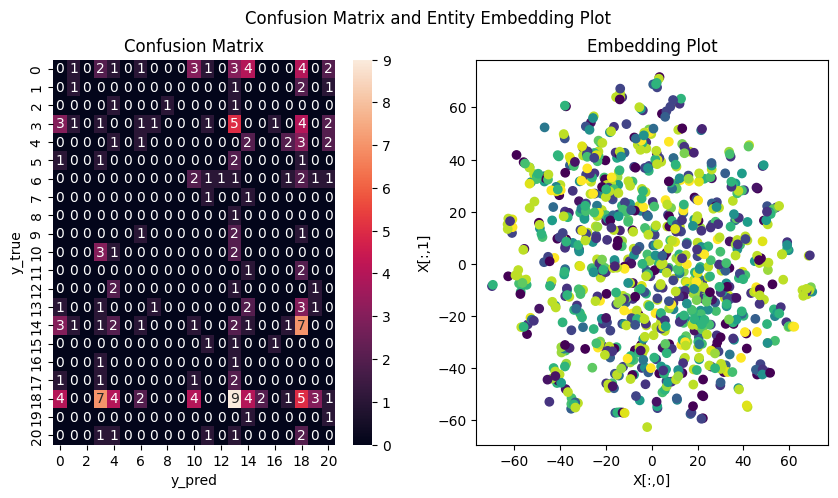

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        22
         1.0       0.25      0.20      0.22         5
         2.0       0.00      0.00      0.00         3
         3.0       0.05      0.05      0.05        20
         4.0       0.08      0.09      0.08        11
         5.0       0.00      0.00      0.00         5
         6.0       0.00      0.00      0.00        10
         7.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         4
        10.0       0.00      0.00      0.00         6
        11.0       0.00      0.00      0.00         3
        12.0       0.00      0.00      0.00         4
        13.0       0.00      0.00      0.00         9
        14.0       0.06      0.05      0.06        20
        15.0       0.00      0.00      0.00         3
        16.0       0.00      0.00      0.00         2
        17.0       0.00    

/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from utils import rf_discriminator_test, get_tsne_emb
X = get_tsne_emb(embedding_dict['user'], perplexity=3)
y_true = hg['user'].occupation.float()

rf_discriminator_test(X,y_true)

## Analysis
From the above results, it should be noted that the generated embeddings,  after being reduced in dimensionality, **DO NOT** contain a high amount of expressive information for each users **occupation**.

Interpretting why the embeddings are not expressive enough to discern the occupation of a user. The #18 occupation, "Student" is the most common occupation in the ML100K dataset. In fact the dataset is imbalance regarding the occupations of users. 

Becuase users are most oftenly "students" the model identifies this trend and suggests the metaphorical statement... 

"regardless of the embedding, most users are students, therefore if I (speaking as the model) am to predict most accurately, I (speaking as the model) should predict that the embedding for a random user is a student."

# (Alternative method) Using a Pytorch Model 
The goal to decode the embeddings then predict the senstive attribute. In doing so, any model that is capable of taking the n-dimensional embeddings from the provided entity, 
and produce outputs of the size of possible classes for the attribute can be used.

In [24]:
# Reinitializing the TSNE embeddings to be a tensor
X = get_tsne_emb(embedding_dict['user'], perplexity=15, return_tensor=True)
y_true = hg['user'].occupation.long()

/Users/deancochran/Dev/ml/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [25]:
from torch_geometric.utils import index_to_mask
# PYTORCH MODEL/TRAINING/TESING HYPERPARAMETERS

args={
    'out_dim':len(y_true.unique()),
    'activation':'softmax',
    'num_workers':0,
    'batch_size':128,
    'criterion':'CELoss',
    'optimizer':'adam',
    'epochs':100
}

In [96]:
from dataset import CustomDataset
from torch.utils.data import DataLoader

# Defining the information fed into the model
entities=np.array(range(X.shape[0]))
np.random.shuffle(entities)
split_percentage=.8
cutoff = int(np.round(entities.shape[0]*split_percentage))

# Split and define train_loader
train_set = CustomDataset(entities[:cutoff])
train_loader = DataLoader(train_set, num_workers=args['num_workers'], batch_size=args['batch_size'])

# Split and define test_loader
test_set = CustomDataset(entities[cutoff:])
test_loader = DataLoader(test_set, num_workers=args['num_workers'], batch_size=args['batch_size'])

In [97]:
# from model import Discriminator
from utils import get_activation

# Define a Neural Network
activation=get_activation(args['activation'])
discriminator=Discriminator(hidden_dim = X.shape[1], out_dim=args['out_dim'], activation=activation, num_layers=4, dropout=0.3, relu = 0.2)

In [98]:
# Define a loss function, optimizer
from utils import get_criterion, get_optimizer
loss_fn = get_criterion(args['criterion'])
opt = get_optimizer(args['optimizer'],discriminator.parameters())

Train Loss: 2.92, Train AUC: 0.65, Test Loss: 2.91, Test AUC: 0.64: 100%|█████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.47it/s]


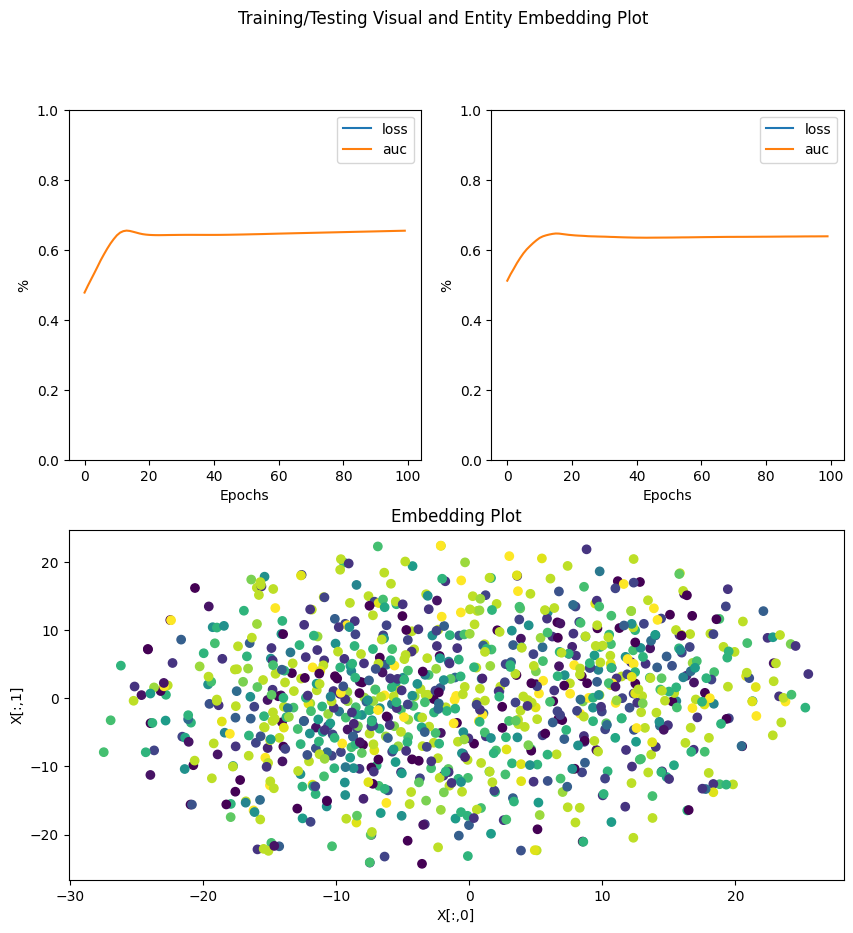

In [99]:
from torch.autograd import Variable
from utils import plot_train_test_embedding
from utils import get_roc_auc
import tqdm

def test_discriminator(test_loader,discriminator, y_true, num_ents, out_dim):
    probs_list, labels_list = [], []
    for p_batch in test_loader:
        p_batch_var = Variable(p_batch).to(device)
        mask=index_to_mask(p_batch_var, num_ents)
        p_batch_emb=X[mask].detach()
        y_hat = discriminator(p_batch_emb)
        
        # change from binary classification here
        y = Variable(torch.nn.functional.one_hot(y_true[mask].detach(), out_dim).float()).to(device)
        
        probs_list.append(y_hat)
        labels_list.append(y)
        
    Y = torch.cat(labels_list,0)
    Y_hat = torch.cat(probs_list,0)
    loss = loss_fn(Y_hat,Y)
    auc = get_roc_auc(Y.data.cpu().numpy(), Y_hat.data.cpu().numpy(), name='multi')
    return loss, auc

discriminator.eval()
train_loss_vals, test_loss_vals = [], []
train_auc_vals, test_auc_vals = [], []
dataloader=tqdm.tqdm(range(1, args['epochs']+1)) 
for epoch in dataloader:
    probs_list, labels_list = [], []
    for p_batch in train_loader:
        p_batch_var = Variable(p_batch).to(device)
        mask=index_to_mask(p_batch_var, X.shape[0])
        p_batch_emb=X[mask].detach()
        y_hat = discriminator(p_batch_emb)
        
        # change from binary classification here
        y = Variable(torch.nn.functional.one_hot(y_true[mask].detach(), args['out_dim']).float()).to(device)

        loss = loss_fn(y_hat,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # add predictions and trues to data collections
        probs_list.append(y_hat)
        labels_list.append(y)
        

    Y = torch.cat(labels_list,0)
    Y_hat = torch.cat(probs_list,0)
    
    train_auc = torch.tensor(0)
    train_auc = get_roc_auc(Y.data.cpu().numpy(), Y_hat.data.cpu().numpy(), name='multi')
    train_loss = loss_fn(Y_hat, Y)
    
    # test model
    test_loss, test_auc = test_discriminator(test_loader, discriminator, y_true, X.shape[0], args['out_dim'])
    
    # add vals to data collections
    train_loss_vals.append(train_loss.item())
    test_loss_vals.append(test_loss.item())
    train_auc_vals.append(train_auc.item())
    test_auc_vals.append(test_auc.item())
    dataloader.set_description(f'Train Loss: {train_loss:.2f}, Train AUC: {train_auc:.2f}, Test Loss: {test_loss:.2f}, Test AUC: {test_auc:.2f}')

plot_train_test_embedding(args['epochs'],train_loss_vals,test_loss_vals, train_auc_vals, test_auc_vals, X, hg['user'].occupation.float())

<AxesSubplot:>

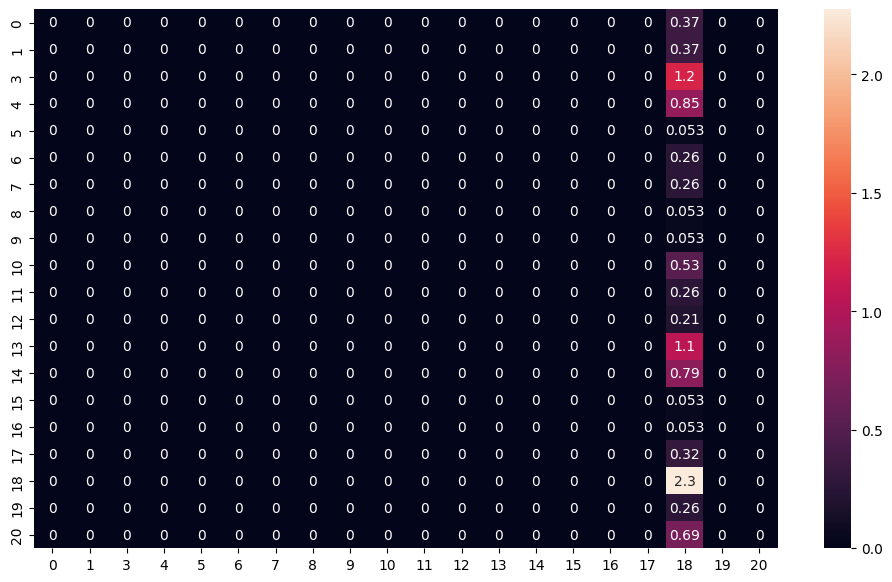

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred_ = []
y_true_ = []

# iterate over test data
for p_batch in test_loader:
        p_batch_var = Variable(p_batch).to(device)
        mask=index_to_mask(p_batch_var, X.shape[0])
        p_batch_emb=X[mask].detach()
        y_hat = discriminator(p_batch_emb)
        # change from binary classification here
        y = y_true[mask].detach()
        
        for y, pred in zip(y.detach().numpy(), y_hat.detach().numpy()):
            y_pred_.append(pred.argmax())
            y_true_.append(y)

unique_y_true_=np.unique(y_true_)
available_classes=[index for name, index in dataset.get_mapping('user','occupation').items() if index in unique_y_true_]

# Build confusion matrix
cf_matrix = confusion_matrix(y_true_, y_pred_)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = available_classes, columns = available_classes)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

## Analysis
This is where I find neural networks show a lot of vital flaws. From the above results, you can clearly see that the model utilizes the fact that most users are students too an extreme

From the above results, it should be noted that the generated embeddings, even after being reduced in dimensionality, **DO NOT** contain a high amount of expressive information for each users **occupation**.